In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Model ,models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics


Bad key "text.kerning_factor" on line 4 in
C:\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
LABELS = ['Normal', 'Break']

df = pd.read_csv('./processminer-rare-event-mts - data.csv')
df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [5]:
df.shape

(18398, 63)

In [6]:
Counter(df['y'])

Counter({0: 18274, 1: 124})

In [7]:
sign = lambda x: (1,-1)[x<0]

In [8]:
sign

<function __main__.<lambda>(x)>

In [9]:
def curve_shift(df, shift_by):
    
    vector = df['y'].copy()
    
    for s in range(abs(shift_by)):
        
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
        
    labelcol = 'y'
    
    df.insert(loc=0, column = labelcol+ 'tmp', value=vector)
    
    df = df.drop(df[df[labelcol] ==1].index)
    
    df = df.drop(labelcol, axis = 1)
    df = df.rename(columns = {labelcol + 'tmp':labelcol})
    
    df.loc[df[labelcol] > 0, labelcol] = 1
    
    return df 
    

In [10]:
shifted_df = curve_shift(df, shift_by=-5)
shifted_df.head()

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,0.0,5/1/99 0:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,0.0,5/1/99 0:02,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,0.0,5/1/99 0:04,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,0.0,5/1/99 0:06,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,0.0,5/1/99 0:08,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [11]:
shifted_df = shifted_df.drop(['time','x28','x61'], axis=1)

In [12]:
input_x = shifted_df.drop('y', axis=1).values
input_y = shifted_df['y'].values

In [13]:
n_features = input_x.shape[1]

In [14]:
n_features

59

In [15]:
def temporalize(X, y , timesteps):
    
    output_X = []
    output_y = []
    
    for i in range(len(X) - timesteps  -1):
        
        t = []
        
        for j in range(1, timesteps + 1):
            
            t.append(X[[(i+j+1)], :])
            
        output_X.append(t)
        output_y.append(y[i + timesteps + 1])
        
    return np.squeeze(np.array(output_X)), np.array(output_y)          
            

In [16]:
timesteps = 5

In [17]:
x, y = temporalize(input_x, input_y, timesteps)

In [18]:
print(x.shape) # (18268, 5, 59)

(18268, 5, 59)


In [21]:
x[0]

array([[ 3.63848490e-01, -4.68139380e+00, -4.35314680e+00,
         1.41279975e+01, -1.38635700e-01, -1.78366320e+01,
         1.08034800e-02, -6.11137000e-02, -3.00566000e-02,
        -1.83524000e-02,  1.00490997e+00,  6.51501500e-02,
        -9.61959620e+00,  1.01148310e-01,  4.10948800e-02,
         2.52838570e-01, -2.35392480e+00, -9.35823600e-01,
         3.07519949e+00,  1.23153750e-01, -1.04334200e-01,
        -5.79012800e-01, -9.78445570e+00,  3.64355970e-01,
         1.59728854e+01, -4.48926500e-01, -9.71440000e-02,
        -1.33946590e+02,  5.87905600e-02, -8.46579000e-02,
         9.03740897e+00,  2.14765000e-03, -6.78381870e+01,
         4.80991391e+00, -2.25266900e-01, -1.86801200e-01,
        -4.86964000e-02, -7.38229000e-02, -7.20746200e-01,
        -1.08516630e+00,  7.96841541e+01, -6.32727500e-01,
         1.36812309e+03, -3.77755000e-02, -5.19541000e-01,
        -1.09086580e+02,  8.54360900e-02,  1.85828926e+01,
         1.12863659e+01,  2.99846242e+01,  1.01002654e+0

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, 
                                                      y_train,
                                                      test_size=0.2)

In [23]:
print(len(x_train))  # 11691
print(len(x_valid))  # 2923
print(len(x_test))   # 3654

11691
2923
3654


In [24]:
# For training the autoencoder, split 0 / 1
x_train_y0 = x_train[y_train == 0]
x_train_y1 = x_train[y_train == 1]

x_valid_y0 = x_valid[y_valid == 0]
x_valid_y1 = x_valid[y_valid == 1]

In [25]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [26]:
def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [27]:
scaler = StandardScaler().fit(flatten(x_train_y0))

In [28]:
x_train_y0_scaled = scale(x_train_y0, scaler)
x_valid_scaled = scale(x_valid, scaler)
x_valid_y0_scaled = scale(x_valid_y0, scaler)
x_test_scaled = scale(x_test, scaler)

In [29]:
epochs = 200
batch = 128
lr = 0.001

In [32]:
lstm_ae = models.Sequential()

In [33]:
# Encoder
lstm_ae.add(layers.LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=False))
lstm_ae.add(layers.RepeatVector(timesteps))
# Decoder
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(32, activation='relu', return_sequences=True))
lstm_ae.add(layers.TimeDistributed(layers.Dense(n_features)))

In [34]:
lstm_ae.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 32)             11776     
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 16)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 59)             1947      
Total params: 25,243
Trainable params: 25,243
Non-trainable params: 0
__________________________________________________

In [35]:
# compile
lstm_ae.compile(loss='mse', optimizer=optimizers.Adam(lr))

In [36]:
# fit
history = lstm_ae.fit(x_train_y0_scaled, x_train_y0_scaled,
                     epochs=epochs, batch_size=batch,
                     validation_data=(x_valid_y0_scaled, x_valid_y0_scaled))

Epoch 1/200
89/89 [==============================] - 1s 13ms/step - loss: 0.8859 - val_loss: 0.7047
Epoch 2/200
89/89 [==============================] - 1s 7ms/step - loss: 0.5613 - val_loss: 0.4650
Epoch 3/200
89/89 [==============================] - 1s 7ms/step - loss: 0.4007 - val_loss: 0.3678
Epoch 4/200
89/89 [==============================] - 1s 10ms/step - loss: 0.3351 - val_loss: 0.3237
Epoch 5/200
89/89 [==============================] - 1s 8ms/step - loss: 0.2999 - val_loss: 0.2947
Epoch 6/200
89/89 [==============================] - 1s 7ms/step - loss: 0.2753 - val_loss: 0.2776
Epoch 7/200
89/89 [==============================] - 1s 9ms/step - loss: 0.2595 - val_loss: 0.2605
Epoch 8/200
89/89 [==============================] - 1s 9ms/step - loss: 0.2470 - val_loss: 0.2501
Epoch 9/200
89/89 [==============================] - 1s 7ms/step - loss: 0.2372 - val_loss: 0.2444
Epoch 10/200
89/89 [==============================] - 1s 7ms/step - loss: 0.2307 - val_loss: 0.2355
Epoch 1

89/89 [==============================] - 1s 10ms/step - loss: 0.1349 - val_loss: 0.1416
Epoch 83/200
89/89 [==============================] - 1s 14ms/step - loss: 0.1336 - val_loss: 0.1409
Epoch 84/200
89/89 [==============================] - 1s 11ms/step - loss: 0.1332 - val_loss: 0.1419
Epoch 85/200
89/89 [==============================] - 1s 12ms/step - loss: 0.1334 - val_loss: 0.1415
Epoch 86/200
89/89 [==============================] - 1s 8ms/step - loss: 0.1322 - val_loss: 0.1407
Epoch 87/200
89/89 [==============================] - 1s 7ms/step - loss: 0.1338 - val_loss: 0.1421
Epoch 88/200
89/89 [==============================] - 1s 8ms/step - loss: 0.1415 - val_loss: 0.1452
Epoch 89/200
89/89 [==============================] - 1s 8ms/step - loss: 0.1396 - val_loss: 0.1413
Epoch 90/200
89/89 [==============================] - 1s 11ms/step - loss: 0.1340 - val_loss: 0.1404
Epoch 91/200
89/89 [==============================] - 1s 9ms/step - loss: 0.1321 - val_loss: 0.1392
Epoch 92

89/89 [==============================] - 1s 8ms/step - loss: 0.1236 - val_loss: 0.1331
Epoch 164/200
89/89 [==============================] - 1s 7ms/step - loss: 0.1237 - val_loss: 0.1313
Epoch 165/200
89/89 [==============================] - 1s 7ms/step - loss: 0.1232 - val_loss: 0.1313
Epoch 166/200
89/89 [==============================] - 1s 7ms/step - loss: 0.1224 - val_loss: 0.1313
Epoch 167/200
89/89 [==============================] - 1s 8ms/step - loss: 0.1223 - val_loss: 0.1335
Epoch 168/200
89/89 [==============================] - 1s 7ms/step - loss: 0.1237 - val_loss: 0.1327
Epoch 169/200
89/89 [==============================] - 1s 7ms/step - loss: 0.1225 - val_loss: 0.1301
Epoch 170/200
89/89 [==============================] - 1s 8ms/step - loss: 0.1219 - val_loss: 0.1304
Epoch 171/200
89/89 [==============================] - 1s 8ms/step - loss: 0.1233 - val_loss: 0.1334
Epoch 172/200
89/89 [==============================] - 1s 9ms/step - loss: 0.1234 - val_loss: 0.1313
Epoc

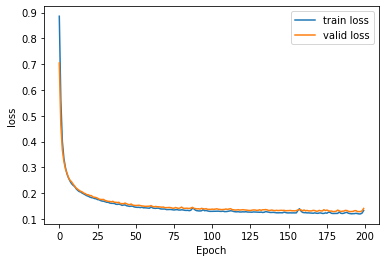

In [37]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [38]:
valid_x_predictions = lstm_ae.predict(x_valid_scaled)

In [40]:
mse = np.mean(np.power(flatten(x_valid_scaled) - flatten(valid_x_predictions),
                       2), axis=1)

In [41]:
error_df = pd.DataFrame({'Reconstruction_error':mse, 
                         'True_class':list(y_valid)})

In [42]:
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], 
                                                                       error_df['Reconstruction_error'])

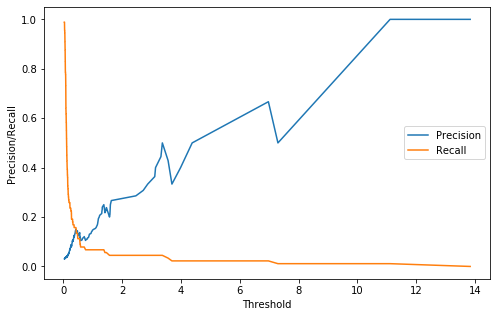

In [43]:
plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [44]:
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

precision:  0.14606741573033707 , recall:  0.14606741573033707


In [45]:
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

threshold:  0.44008860304168507


In [46]:
test_x_predictions = lstm_ae.predict(x_test_scaled)
mse = np.mean(np.power(flatten(x_test_scaled) - flatten(test_x_predictions), 
                       2), axis=1)

In [47]:
error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_test.tolist()})

In [48]:
groups = error_df.groupby('True_class')

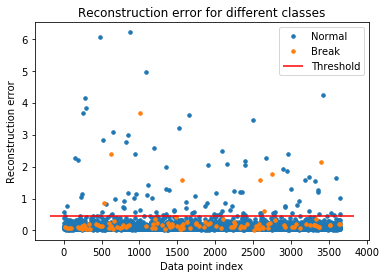

In [49]:
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

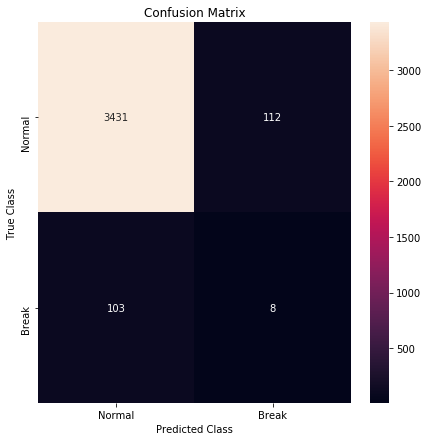

In [50]:
# classification by threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]

conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

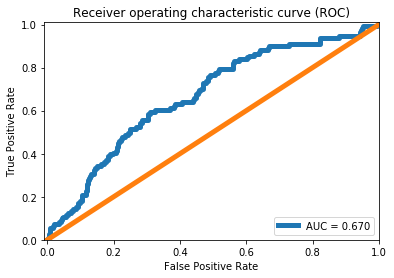

In [52]:
false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(error_df['True_class'], error_df['Reconstruction_error'])
roc_auc = metrics.auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
plt.show()

In [53]:
pred_y[-5:] 

[1, 1, 0, 0, 0]